# Logistic Regression (applied to dummy data)

In [31]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

RANDOM_SEED = 734236

# Load data and plot

In [32]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/test/dummy_data.csv')
data

,1200,1300,1400,1500,1600,1700,code,label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta


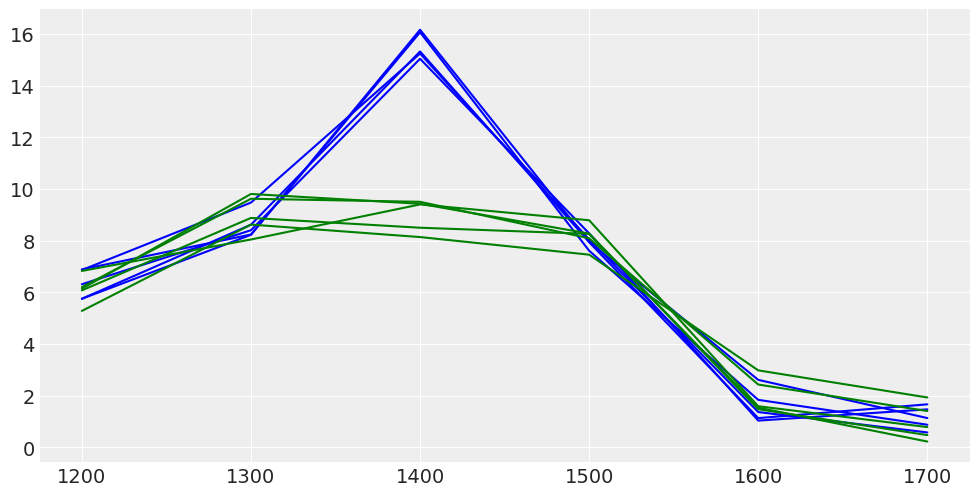

In [33]:
# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

for i in range(len(data)):
    y_val = data.values[i]
    if y_val[-2] == 1:
        col = 'blue'
    else:
        col = 'green'
    plt.plot(x_val, y_val[:-2], '-', color=col);

In [34]:
# extract X data from dataframe
X = data.iloc[:,:-2].to_numpy()
X.shape

(10, 6)

In [35]:
# extract Y data from dataframe
Y = data.iloc[:,-2].to_numpy()
Y.shape

(10,)

In [36]:
# add a column of ones to X
Xn = np.append(np.ones((X.shape[0],1)), X, axis=1)
Xn.shape

(10, 7)

# Model definition (Multiple Linear Regression)

In [37]:
with pm.Model() as model_mlr:
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=Xn.shape[1])
    epsilon = pm.HalfNormal('epsilon', 10)
    
    mu = pm.math.dot(Xn, beta)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=Y)

    trace_mlr = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:09<00:00, 85.90draws/s] 
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.592831660443405, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


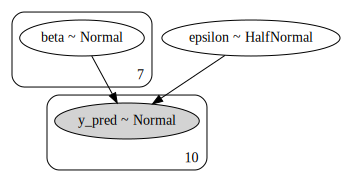

In [38]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [39]:
az.summary(trace_mlr)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.133,0.497,-0.713,1.093,0.026,0.021,365.0,290.0,376.0,468.0,1.01
beta[1],0.088,0.162,-0.222,0.401,0.005,0.003,1096.0,1096.0,1012.0,1539.0,1.00
beta[2],0.070,0.102,-0.119,0.260,0.004,0.003,754.0,754.0,579.0,1900.0,1.01
beta[3],-0.138,0.025,-0.185,-0.092,0.001,0.001,1038.0,983.0,932.0,1414.0,1.00
beta[4],0.209,0.147,-0.063,0.488,0.005,0.004,972.0,759.0,909.0,468.0,1.01
beta[5],0.073,0.132,-0.195,0.283,0.005,0.004,676.0,676.0,506.0,1471.0,1.01
beta[6],0.081,0.149,-0.189,0.382,0.005,0.003,934.0,934.0,841.0,1705.0,1.01
epsilon,0.197,0.099,0.100,0.359,0.005,0.003,421.0,421.0,170.0,231.0,1.00


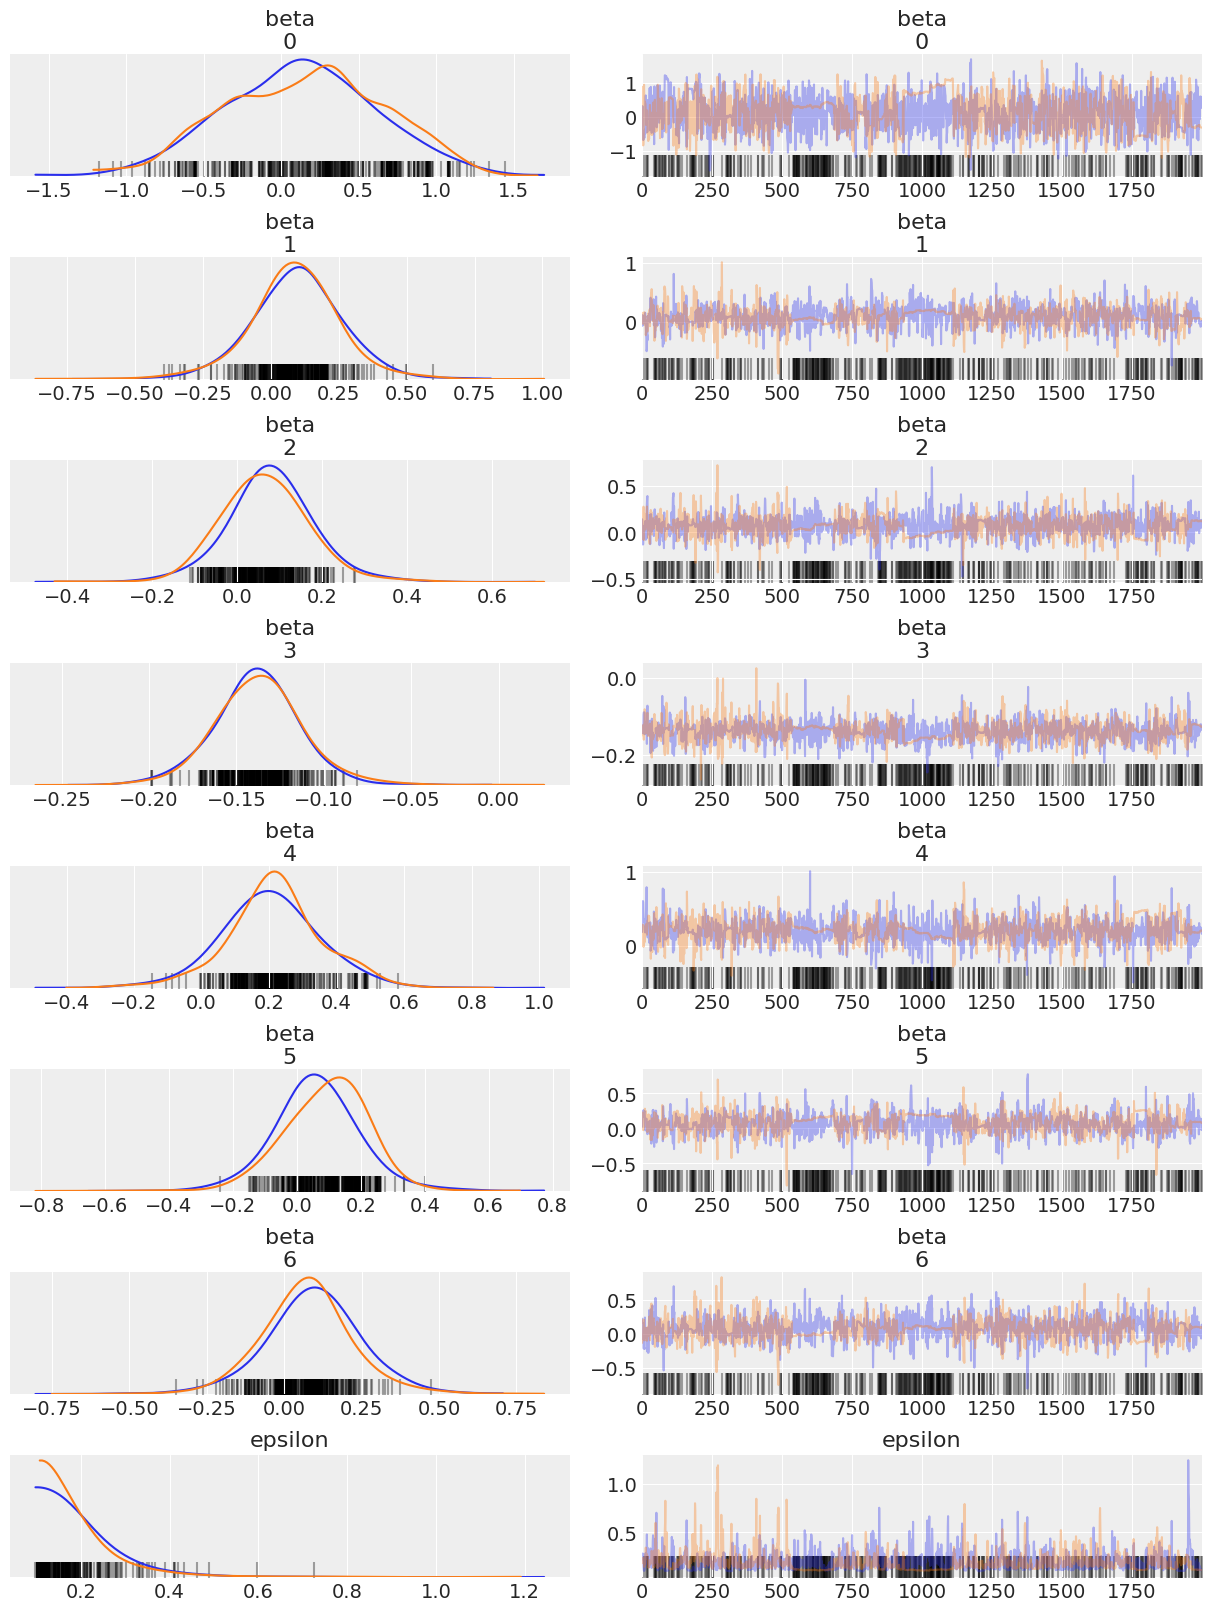

In [40]:
az.plot_trace(trace_mlr);

In [41]:
#az.plot_posterior(trace_mlr);

In [42]:
#az.plot_autocorr(trace_mlr);

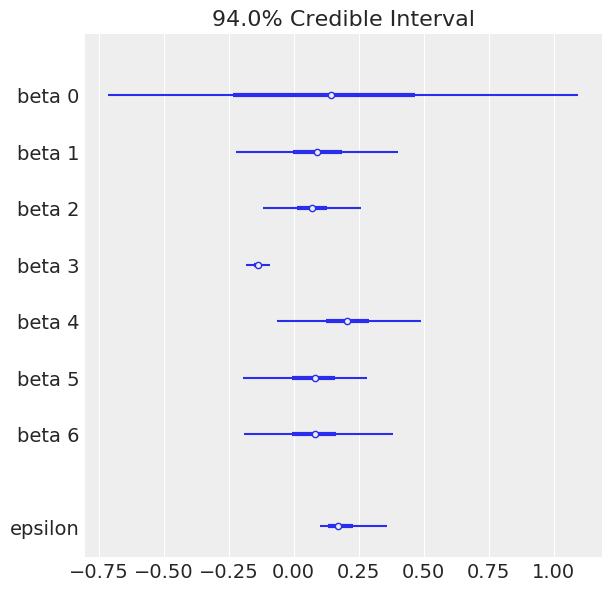

In [43]:
az.plot_forest(trace_mlr, combined=True);

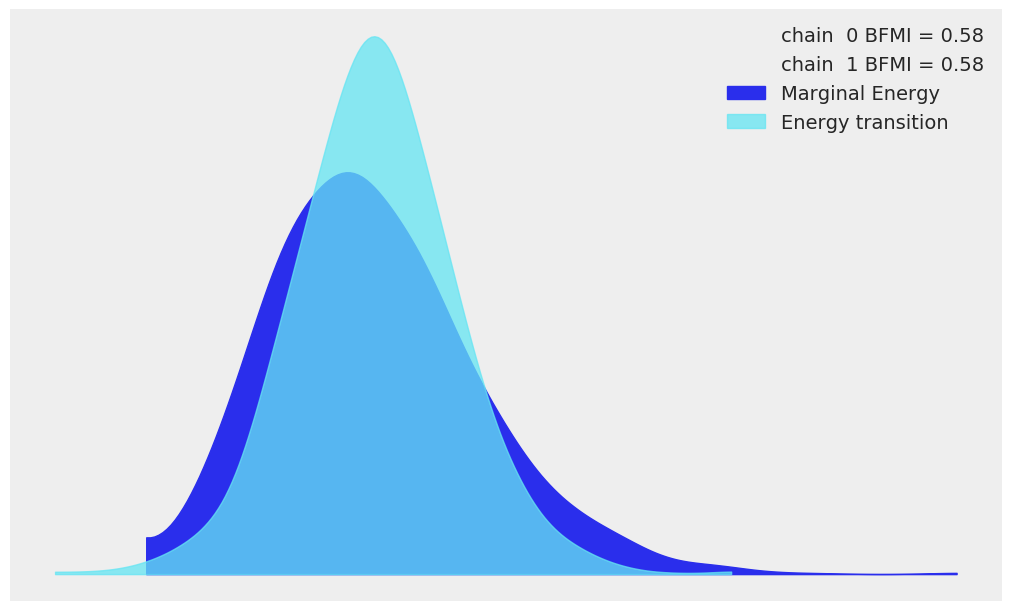

In [44]:
az.plot_energy(trace_mlr, figsize=(10, 6));

In [45]:
ppc = pm.sample_posterior_predictive(trace_mlr, samples=100, model=model_mlr)

100%|██████████| 100/100 [00:00<00:00, 439.58it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


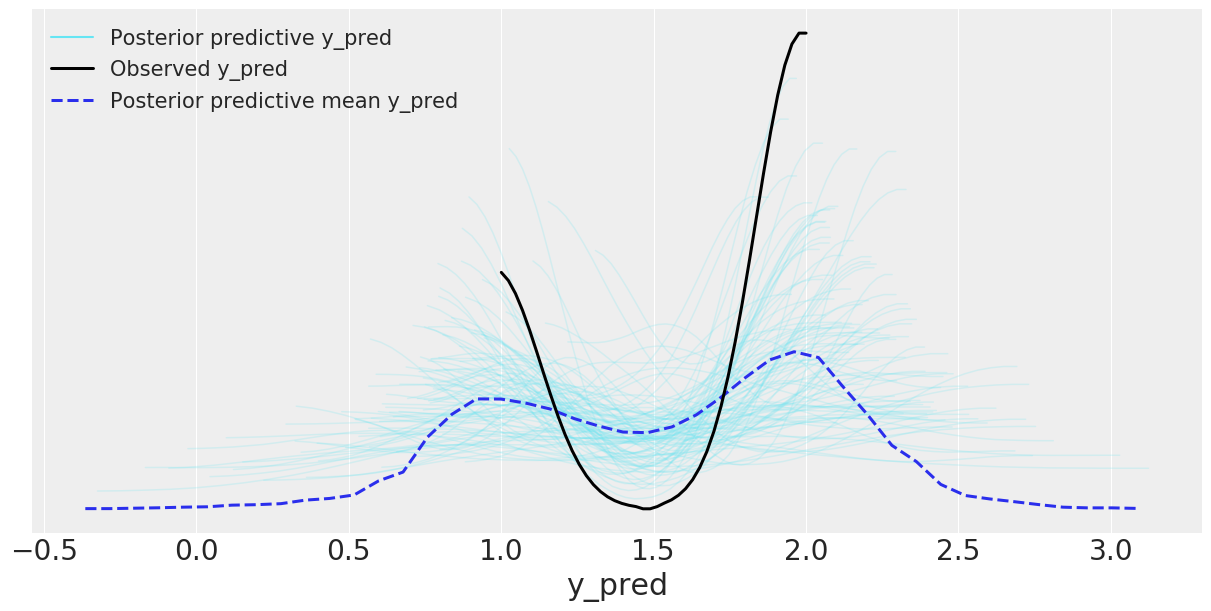

In [46]:
data_ppc = az.from_pymc3(trace=trace_mlr, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

# Model definition (Multiple Logistic Regression)

In [47]:
# extract X and Y data from dataframe
Y = pd.Categorical(data['label']).codes
X = data.iloc[:,:-2]

In [48]:
# add a column of ones to X
Xn = np.append(np.ones((X.shape[0],1)), X, axis=1)
Xn.shape

(10, 7)

In [49]:
with pm.Model() as model_lr: 
    beta = pm.Normal('beta', mu=0, sd=10, shape=Xn.shape[1])
    
    mu = pm.math.dot(Xn, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 
 
    trace_lr = pm.sample(2000, tune=1000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:21<00:00, 73.75draws/s]
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


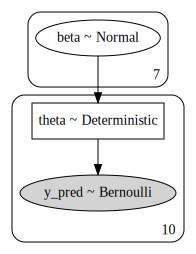

In [50]:
pm.model_to_graphviz(model_lr)

# Model evaluation

In [51]:
varnames = ['beta']
coef = az.summary(trace_lr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.901,9.789,-17.442,18.806,0.220,0.181,1987.0,1459.0,1990.0,1946.0,1.0
beta[1],4.258,8.774,-11.239,21.334,0.225,0.174,1524.0,1271.0,1535.0,1524.0,1.0
beta[2],5.989,7.115,-6.358,20.475,0.194,0.138,1339.0,1339.0,1327.0,1756.0,1.0
beta[3],-11.521,4.710,-19.828,-3.051,0.167,0.118,800.0,800.0,819.0,1339.0,1.0
beta[4],6.501,7.670,-8.331,20.639,0.215,0.152,1276.0,1276.0,1274.0,1832.0,1.0
beta[5],2.356,8.840,-14.165,19.798,0.183,0.174,2341.0,1292.0,2341.0,1999.0,1.0
beta[6],0.892,9.179,-15.876,18.197,0.213,0.164,1862.0,1574.0,1842.0,1869.0,1.0


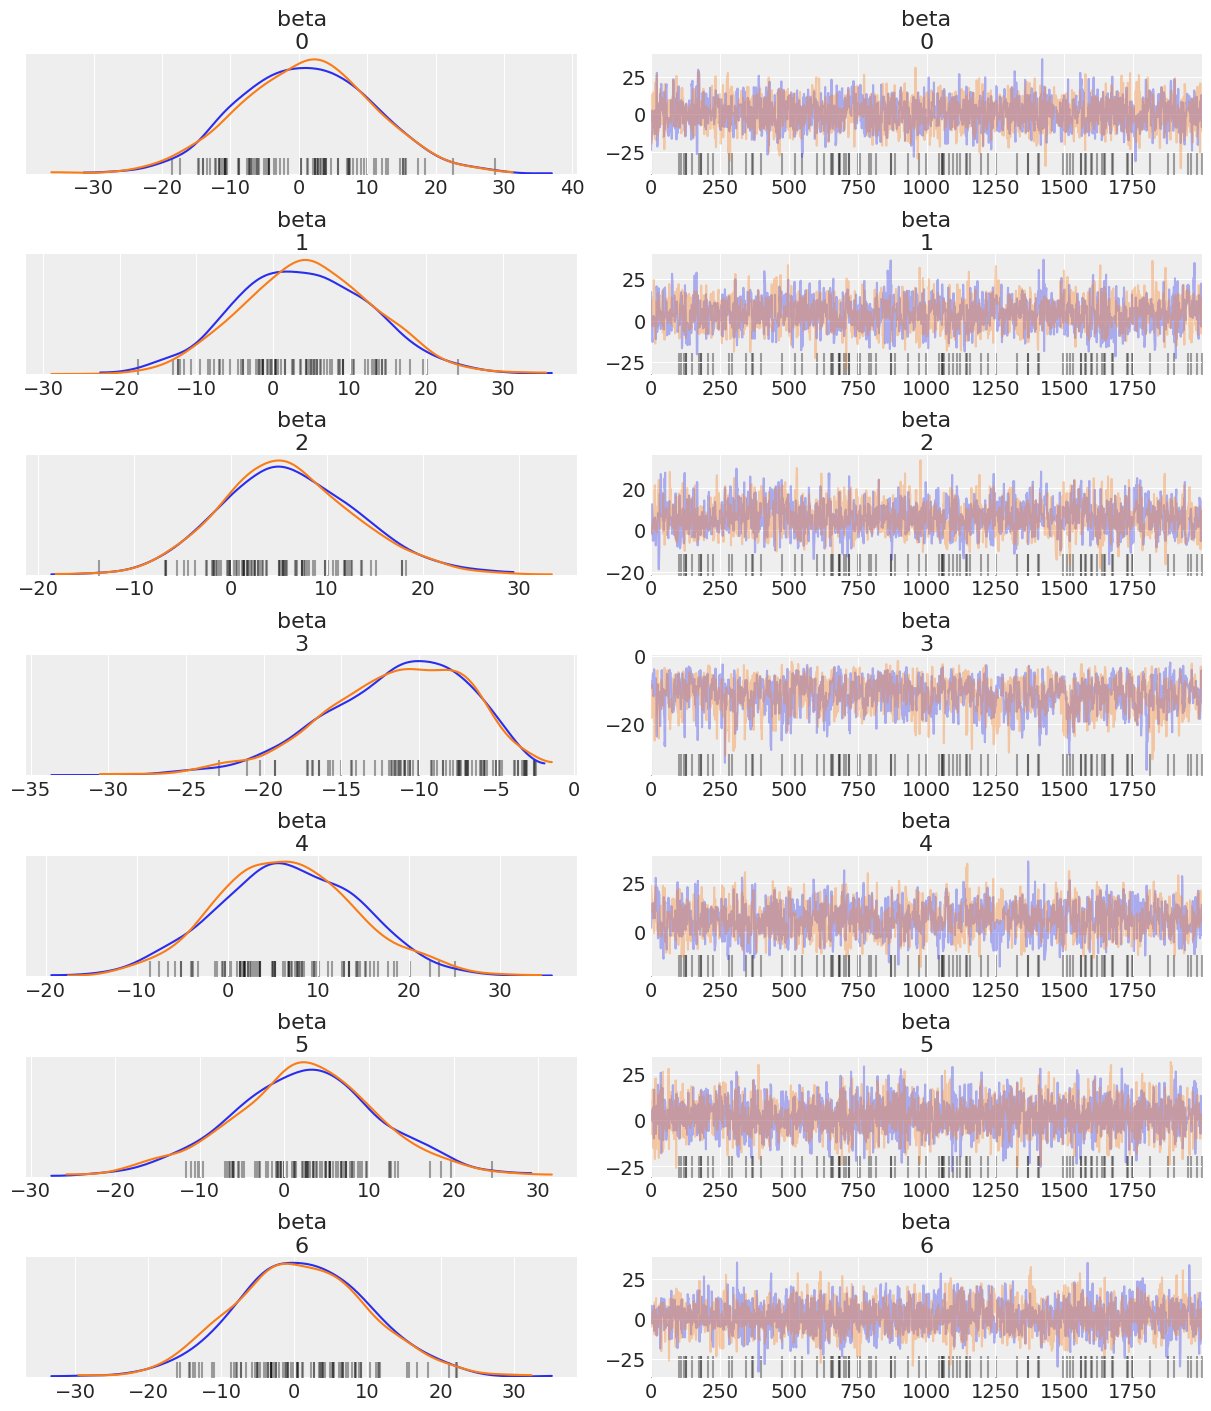

In [52]:
az.plot_trace(trace_lr, varnames);

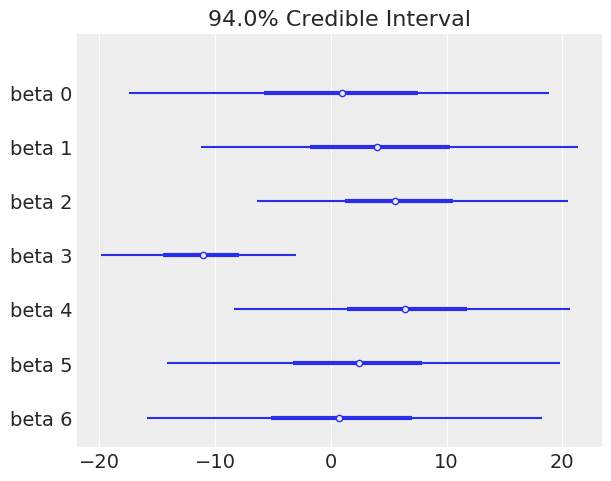

In [53]:
az.plot_forest(trace_lr, var_names=varnames, combined=True);

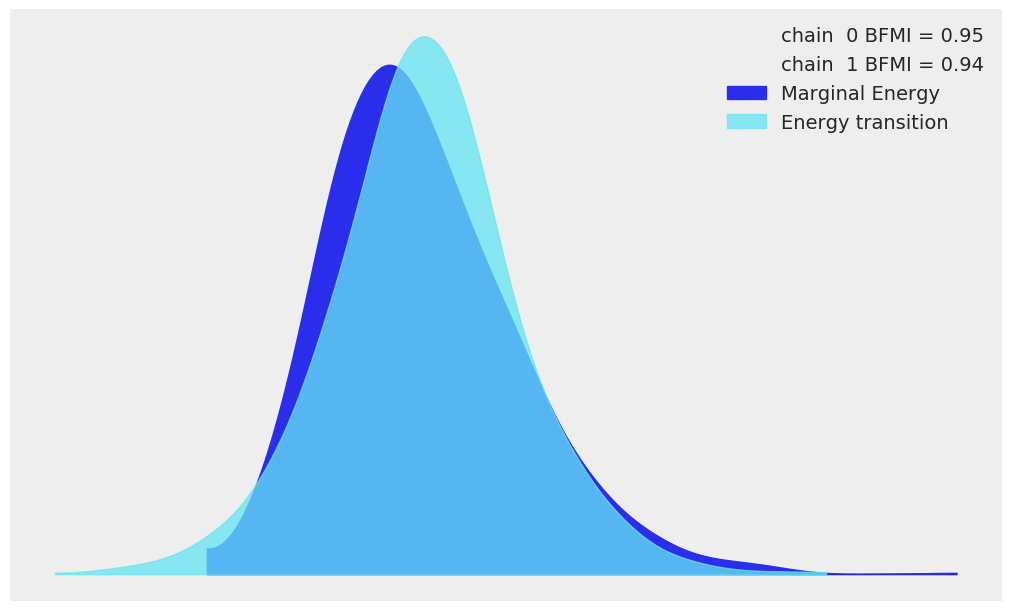

In [54]:
az.plot_energy(trace_lr, figsize=(10, 6));

In [55]:
# check predictions 
from scipy.special import expit as logistic

p_y = np.zeros(len(Xn))
lp = [] 

for i in range(len(Xn)):
    p_y[i] = logistic((coef['mean'] * Xn[i]).sum())
    if (p_y[i] < 0.5): 
        p_y[i] = 0
        lp.append('Arabica')
    else:
        p_y[i] = 1
        lp.append('Robusta')

# add new colums to dataframe
data = data.assign(pred=pd.Series(p_y))
data = data.assign(pred_label=pd.Series(lp))
data

,1200,1300,1400,1500,1600,1700,code,label,pred,pred_label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica,0.0,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica,0.0,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica,0.0,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica,0.0,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica,0.0,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta,1.0,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta,1.0,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta,1.0,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta,1.0,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta,1.0,Robusta
